<a href="https://colab.research.google.com/github/Anaberen/web-scraping-project-tutorial/blob/main/Web_Scraping_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import time
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
# URL del sitio web que contiene los datos url = "https://ycharts.com/companies/TSLA/revenues"
url = "https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"
response = requests.get(url)


#Step 3: Transform the HTML

hdr = {'User-Agent': 'Mozilla/5.0'}
req = Request(url, headers=hdr)
page = urlopen(req)
soup = BeautifulSoup(page, 'html.parser')


#Find all tables

tables = soup.find_all("table", class_ = "historical_data_table table")
tables

[<table class="historical_data_table table">
 <thead>
 <tr>
 <th colspan="2" style="text-align:center">Tesla Annual Revenue<br/><span style="font-size:14px;">(Millions of US $)</span></th>
 </tr>
 </thead>
 <tbody>
 <tr>
 <td style="text-align:center">2023</td>
 <td style="text-align:center">$96,773</td>
 </tr>
 <tr>
 <td style="text-align:center">2022</td>
 <td style="text-align:center">$81,462</td>
 </tr>
 <tr>
 <td style="text-align:center">2021</td>
 <td style="text-align:center">$53,823</td>
 </tr>
 <tr>
 <td style="text-align:center">2020</td>
 <td style="text-align:center">$31,536</td>
 </tr>
 <tr>
 <td style="text-align:center">2019</td>
 <td style="text-align:center">$24,578</td>
 </tr>
 <tr>
 <td style="text-align:center">2018</td>
 <td style="text-align:center">$21,461</td>
 </tr>
 <tr>
 <td style="text-align:center">2017</td>
 <td style="text-align:center">$11,759</td>
 </tr>
 <tr>
 <td style="text-align:center">2016</td>
 <td style="text-align:center">$7,000</td>
 </tr>
 <

In [3]:
table = soup.find('table', class_='tesla-data')
table

In [4]:
for index, table in enumerate(tables):
    if ("Tesla Quarterly Revenue" in str(table)):
        table_index = index
        break

In [5]:
tesla_revenue_table = pd.DataFrame(columns=['fecha', 'beneficios'])
for row in tables[table_index].tbody.find_all('tr'):
    col = row.find_all('td')
    if col != []:
        fecha = col[0].text
        beneficios = col[1].text.replace('$', '').replace(',', '')
        tesla_revenue_table = pd.concat([tesla_revenue_table, pd.DataFrame({
                'fecha': fecha,
                'beneficios': beneficios},
                index=[0])], ignore_index=True)


tesla_revenue_table.head()

,fecha,beneficios
0,2024-06-30,25500
1,2024-03-31,21301
2,2023-12-31,25167
3,2023-09-30,23350
4,2023-06-30,24927


PROCESA EL DATA FRAME

In [6]:
# usamos solo las columnas que no estan vacias y creamos un nuevo df
tesla_revenue = tesla_revenue_table[tesla_revenue_table["beneficios"] != ""]
tesla_revenue.head()

,fecha,beneficios
0,2024-06-30,25500
1,2024-03-31,21301
2,2023-12-31,25167
3,2023-09-30,23350
4,2023-06-30,24927


ALMACENA LOS DATOS EN SQLITE

In [7]:
import sqlite3

connection = sqlite3.connect("Tesla.db")
connection

In [8]:
cursor = connection.cursor()
cursor.execute("""CREATE TABLE beneficios (fecha, beneficios)""")

In [9]:
tesla_tuples = list(tesla_revenue_table.to_records(index = False))
tesla_tuples[:5]

[('2024-06-30', '25500'),
 ('2024-03-31', '21301'),
 ('2023-12-31', '25167'),
 ('2023-09-30', '23350'),
 ('2023-06-30', '24927')]

In [10]:
cursor.executemany("INSERT INTO beneficios VALUES (?,?)", tesla_tuples) # insertamos varios registros a la vez
connection.commit()

In [12]:
for row in cursor.execute("SELECT * FROM beneficios"):
    print(row) #una consulta SQL para obtener todas las filas de la tabla beneficios

('2024-06-30', '25500')
('2024-03-31', '21301')
('2023-12-31', '25167')
('2023-09-30', '23350')
('2023-06-30', '24927')
('2023-03-31', '23329')
('2022-12-31', '24318')
('2022-09-30', '21454')
('2022-06-30', '16934')
('2022-03-31', '18756')
('2021-12-31', '17719')
('2021-09-30', '13757')
('2021-06-30', '11958')
('2021-03-31', '10389')
('2020-12-31', '10744')
('2020-09-30', '8771')
('2020-06-30', '6036')
('2020-03-31', '5985')
('2019-12-31', '7384')
('2019-09-30', '6303')
('2019-06-30', '6350')
('2019-03-31', '4541')
('2018-12-31', '7226')
('2018-09-30', '6824')
('2018-06-30', '4002')
('2018-03-31', '3409')
('2017-12-31', '3288')
('2017-09-30', '2985')
('2017-06-30', '2790')
('2017-03-31', '2696')
('2016-12-31', '2285')
('2016-09-30', '2298')
('2016-06-30', '1270')
('2016-03-31', '1147')
('2015-12-31', '1214')
('2015-09-30', '937')
('2015-06-30', '955')
('2015-03-31', '940')
('2014-12-31', '957')
('2014-09-30', '852')
('2014-06-30', '769')
('2014-03-31', '621')
('2013-12-31', '615')
('20

VISUALIZACIÓN DE SERIES DE TIEMPO

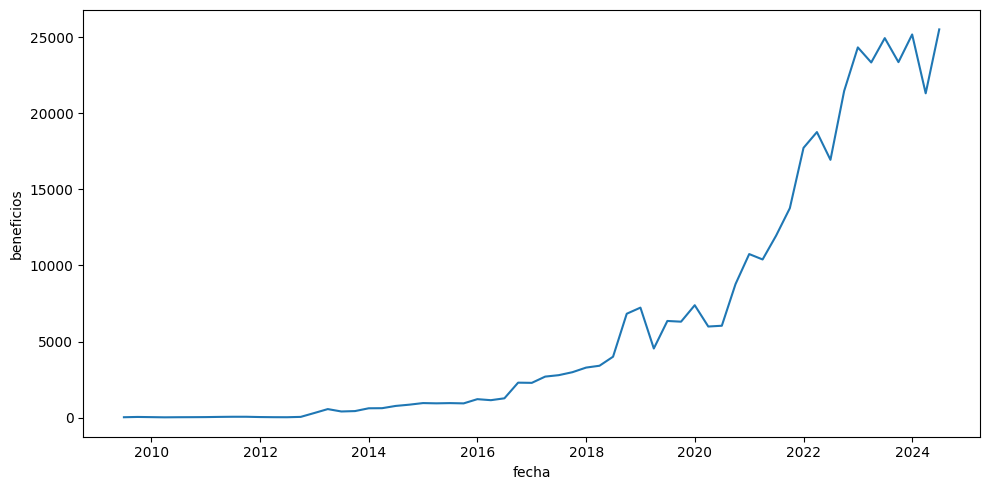

In [16]:
fig, axis = plt.subplots(figsize = (10, 5))

tesla_revenue.loc[:, "fecha"] = pd.to_datetime(tesla_revenue["fecha"])
tesla_revenue.loc[:, "beneficios"] = tesla_revenue["beneficios"].astype('int')
sns.lineplot(data = tesla_revenue, x = "fecha", y = "beneficios")

plt.tight_layout()

plt.show()

BENEFICIO BRUTO ANUAL

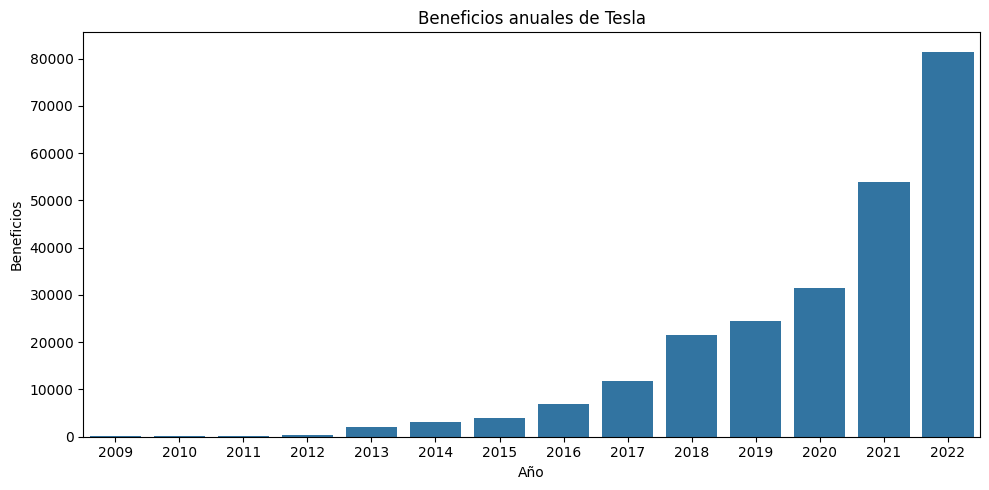

In [18]:
tesla_revenue.loc[:, "fecha"] = pd.to_datetime(tesla_revenue["fecha"])

# Agrupo por año y sumar solo los beneficios para poder sumarlos.
tesla_revenue_yearly = tesla_revenue.groupby(tesla_revenue["fecha"].dt.year)['beneficios'].sum().reset_index()


fig, axis = plt.subplots(figsize=(10, 5))
sns.barplot(data=tesla_revenue_yearly[tesla_revenue_yearly["fecha"] < 2023], x="fecha", y="beneficios")
plt.title("Beneficios anuales de Tesla")
plt.xlabel("Año")
plt.ylabel("Beneficios")
plt.tight_layout()
plt.show()

Se puede observar como a lo largo de los años los beneficios han aumentado favorablemente

BENEFICO BRUTO MENSUAL

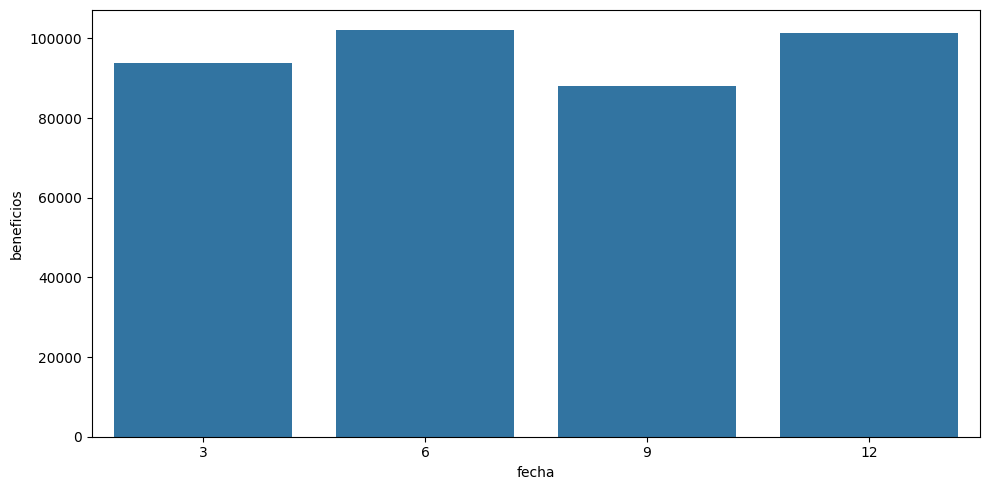

In [20]:
fig, axis = plt.subplots(figsize = (10, 5))

tesla_revenue_monthly = tesla_revenue.groupby(tesla_revenue["fecha"].dt.month)["beneficios"].sum().reset_index() # Nos aseguramos de que solo aplicamos la suma a la columna de 'Beneficios'

sns.barplot(data = tesla_revenue_monthly, x = "fecha", y = "beneficios")

plt.tight_layout()

plt.show()

en este gráfico podemos observas los beneficos a lo largo de los meses